In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

IMAGE_ROOT = "./data/train/DCM"
LABEL_ROOT = "./data/train/outputs_json"
META_ROOT = "./data/meta_data.xlsx"

In [8]:
# 데이터 경로를 입력하세요

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

#
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

print(len(pngs))
print(len(jsons))

jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}


475
800


In [10]:
# assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
# assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

pngs = sorted(pngs)
jsons = sorted(jsons)

In [11]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

In [12]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

tf = A.Resize(512, 512)

train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)
image, label = train_dataset[0]

print(image.shape, label.shape)

print(len(train_dataset))

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])
379


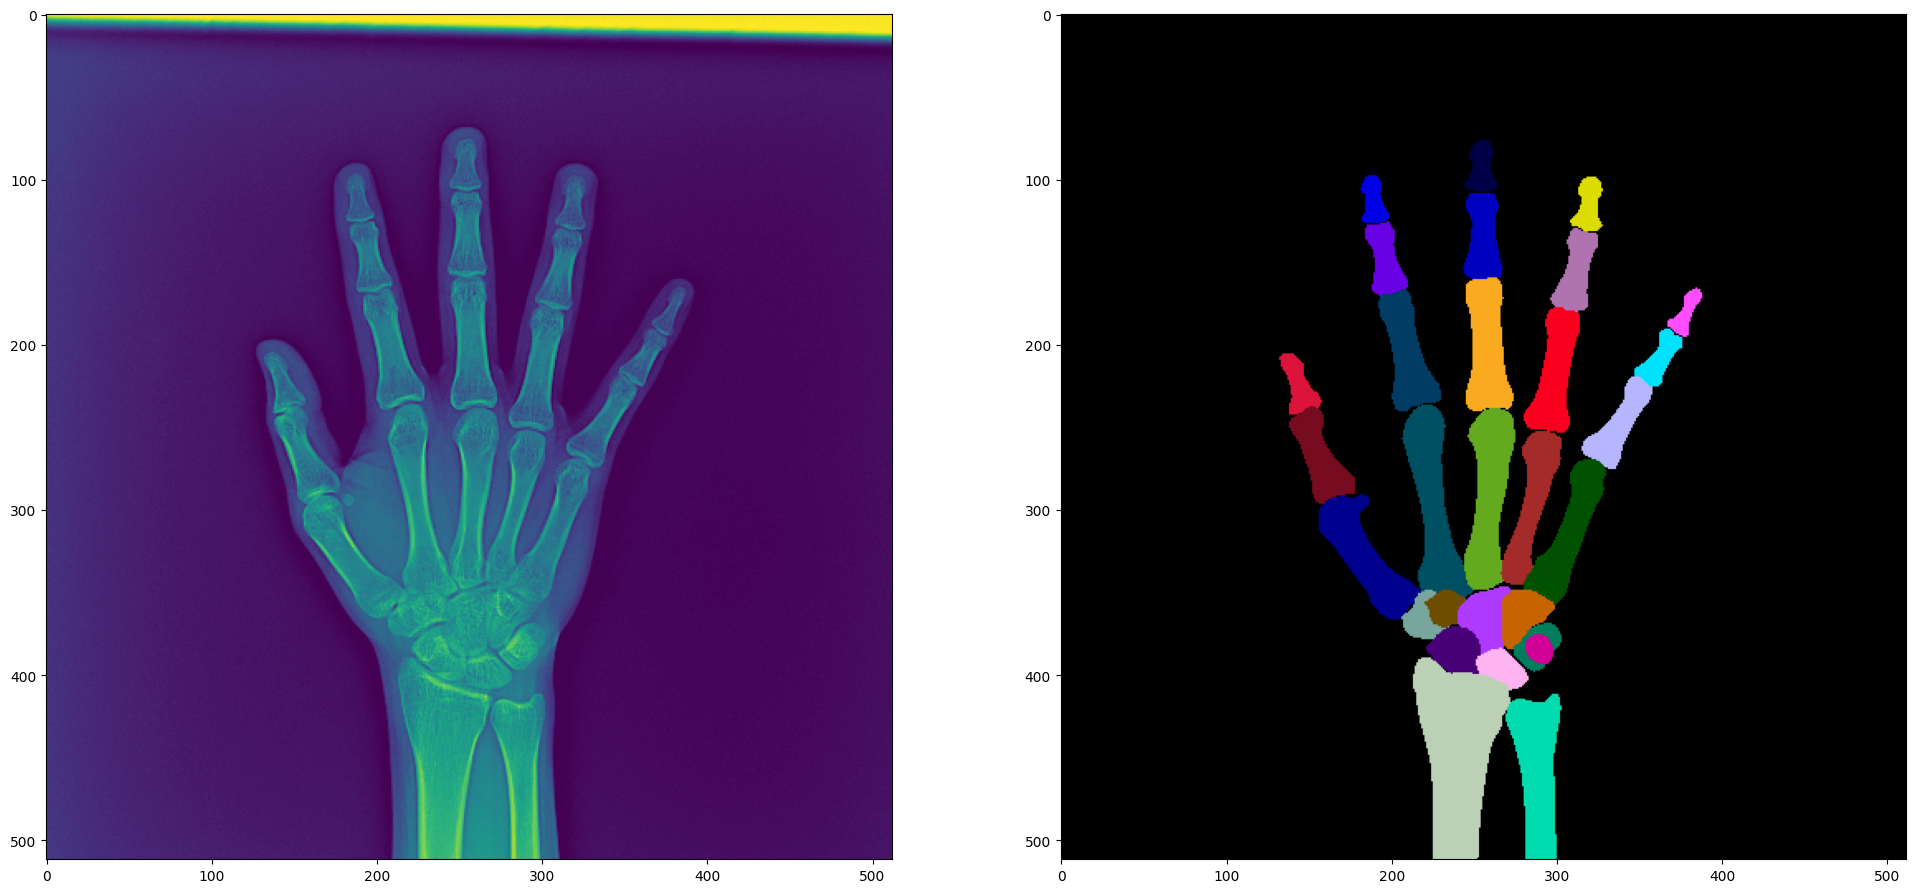

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label))

plt.show()

# EDA
1. 각 이미지 내에서 multi label을 가진 값 pixel count(면적) 비교 
2. 한 이미지 내에서 29개 label 이 모두 등장하는지 여부 

In [ ]:
# train 데이터의 모든 json ㄴㅇ

In [44]:
import os
import json
import pandas as pd

# JSON 파일이 저장된 디렉토리 경로
json_dir = './data/train/outputs_json'

# 데이터프레임을 저장할 리스트
data = []


# 디렉토리 내의 모든 환자 ID 폴더를 탐색
for patient_id in os.listdir(json_dir):
    patient_path = os.path.join(json_dir, patient_id)
    r_flag= 0 #  0 : R , 1:L
    # 각 환자 ID 폴더 내의 모든 JSON 파일을 탐색
    for json_file in os.listdir(patient_path):
        if json_file.endswith('.json'):
            file_path = os.path.join(patient_path, json_file)
            direction = "R" if r_flag == 0 else "L"
            # JSON 파일 읽기
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                
                # 필요한 정보 추출
                for annotation in json_data.get('annotations', []):
                    data.append({
                        'patient_id': patient_id,
                        'img_name': json_file.replace('.json', '.png'),
                        'direction':direction,
                        'annotation': annotation,
                        'id': annotation.get('id'),
                        'type': annotation.get('type'),
                        'attributes': annotation.get('attributes'),
                        'points': annotation.get('points'),
                        'label': annotation.get('label', None)  # label이 없을 경우 None으로 설정
                    })
        r_flag += 1 # left



# DataFrame 생성
df = pd.DataFrame(data)
# df.to_csv('./train_annotation.csv', index=False)
df.to_excel('./train_annotation.xlsx', index=False)
print(df.describe)

<bound method NDFrame.describe of       patient_id                img_name  \
0          ID511  image1666748000469.png   
1          ID511  image1666748000469.png   
2          ID511  image1666748000469.png   
3          ID511  image1666748000469.png   
4          ID511  image1666748000469.png   
...          ...                     ...   
23195      ID369  image1665450304426.png   
23196      ID369  image1665450304426.png   
23197      ID369  image1665450304426.png   
23198      ID369  image1665450304426.png   
23199      ID369  image1665450304426.png   

                                              annotation  \
0      {'id': '1-31483841-001a-477b-925e-7bbd635741e3...   
1      {'id': '2-f23e230d-3188-4149-a689-45ef2a46aed7...   
2      {'id': '3-a8ac60ac-5f29-4aad-afa7-b1e76320c055...   
3      {'id': '4-e5323619-506b-4fa1-b82d-0989b36bcbca...   
4      {'id': '5-6ebe38de-a38d-4016-bcbc-87c4cfa95463...   
...                                                  ...   
23195  {'id': '25

In [45]:
df.to_csv('./train_annotation.csv', index=False)

In [59]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from shapely.geometry import Polygon

def load_annotations(directory):
    annotations = defaultdict(list)
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                img_name = filename.split('.')[0]
                for annotation in data['annotations']:
                    label = annotation['id']
                    points = annotation['points']
                    annotations[img_name].append((label, points))
    return annotations

def calculate_overlap(annotations):
    overlap_areas = {}
    for img_name, segments in annotations.items():
        masks = []
        for label, points in segments:
            polygon = Polygon(points)
            masks.append((label, polygon))
        
        # Calculate overlapping areas
        overlap_area = 0
        for i in range(len(masks)):
            for j in range(i + 1, len(masks)):
                if masks[i][1].intersects(masks[j][1]):
                    intersection = masks[i][1].intersection(masks[j][1])
                    overlap_area += intersection.area
        
        overlap_areas[img_name] = overlap_area
    return overlap_areas

def visualize_overlap(overlap_areas):
    img_names = list(overlap_areas.keys())
    areas = list(overlap_areas.values())
    
    plt.barh(img_names, areas)
    plt.xlabel('Overlap Area')
    plt.title('Multi-label Overlap Areas in Images')
    plt.show()

def main(directory):
    annotations = load_annotations(directory)
    overlap_areas = calculate_overlap(annotations)
    visualize_overlap(overlap_areas)

if __name__ == "__main__":
    main('data/train/outputs_json/ID001/')

ModuleNotFoundError: No module named 'shapely'

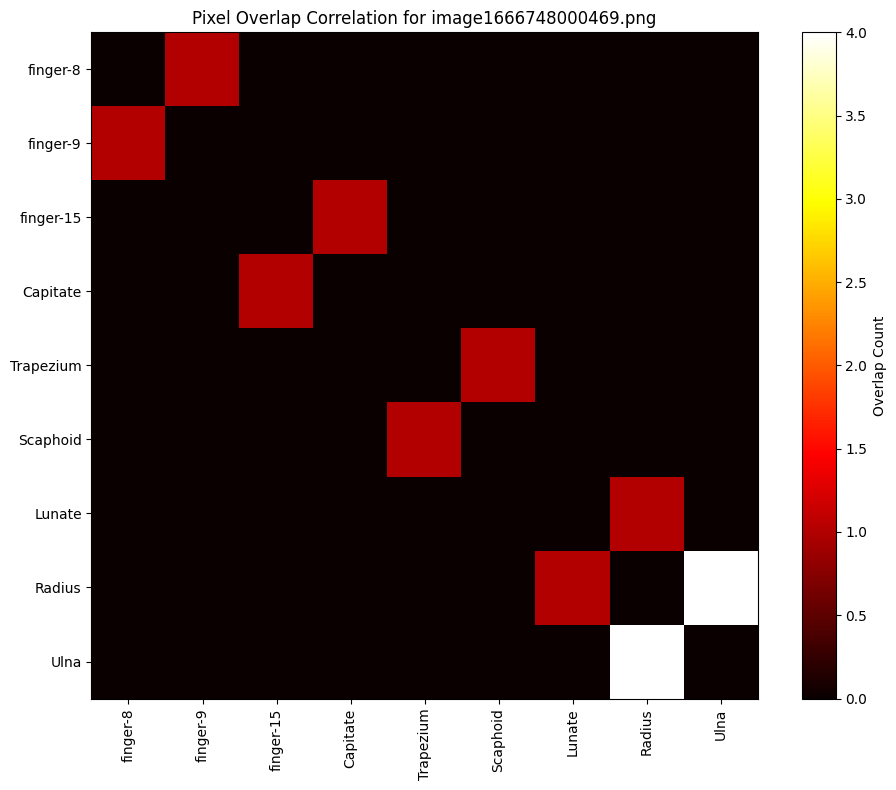

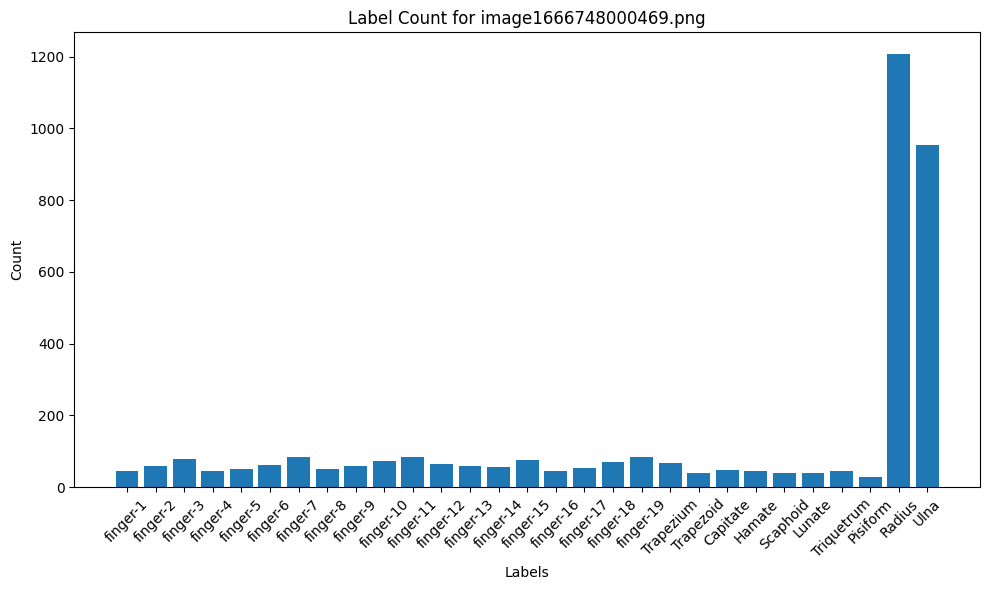

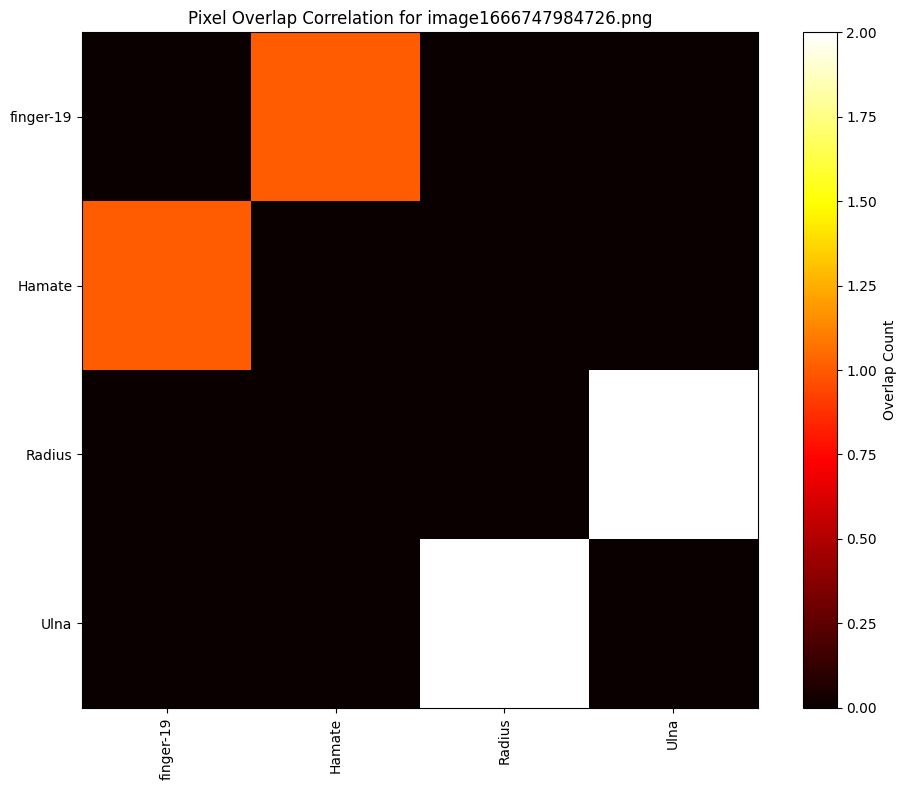

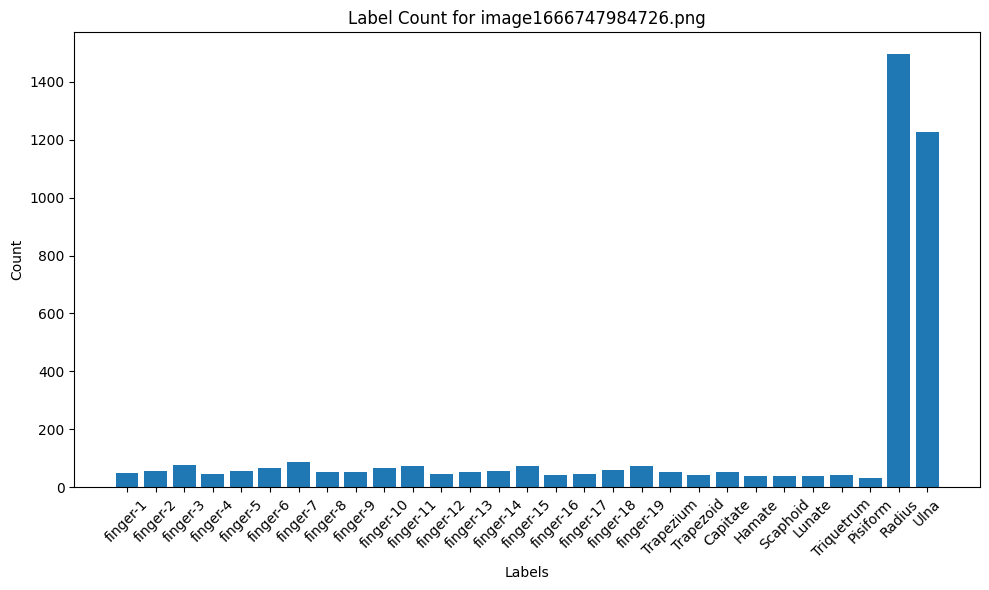

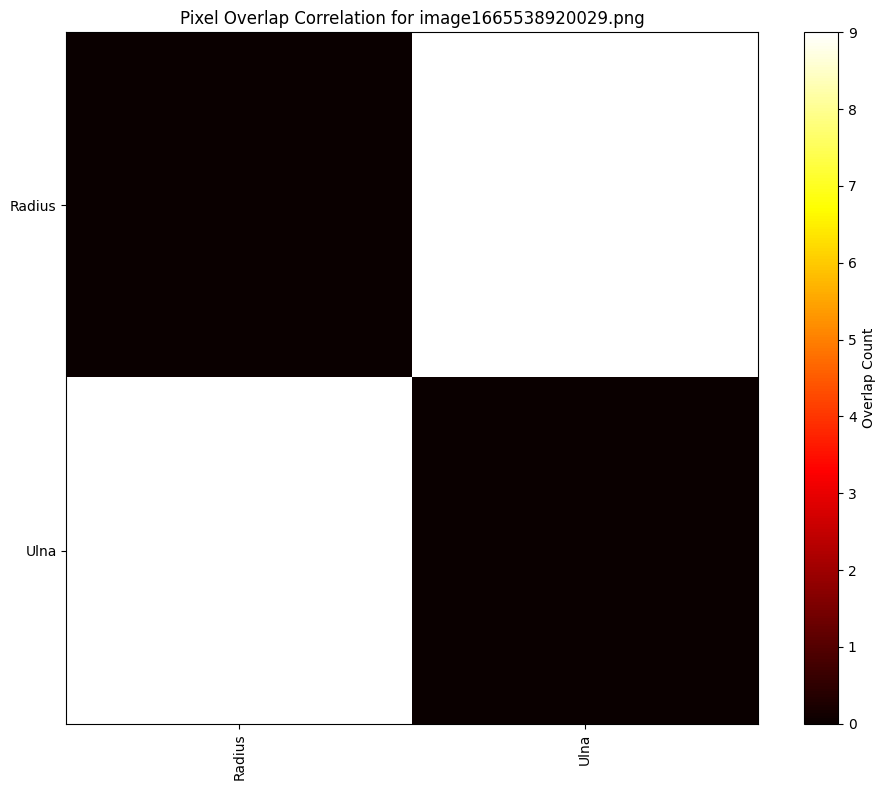

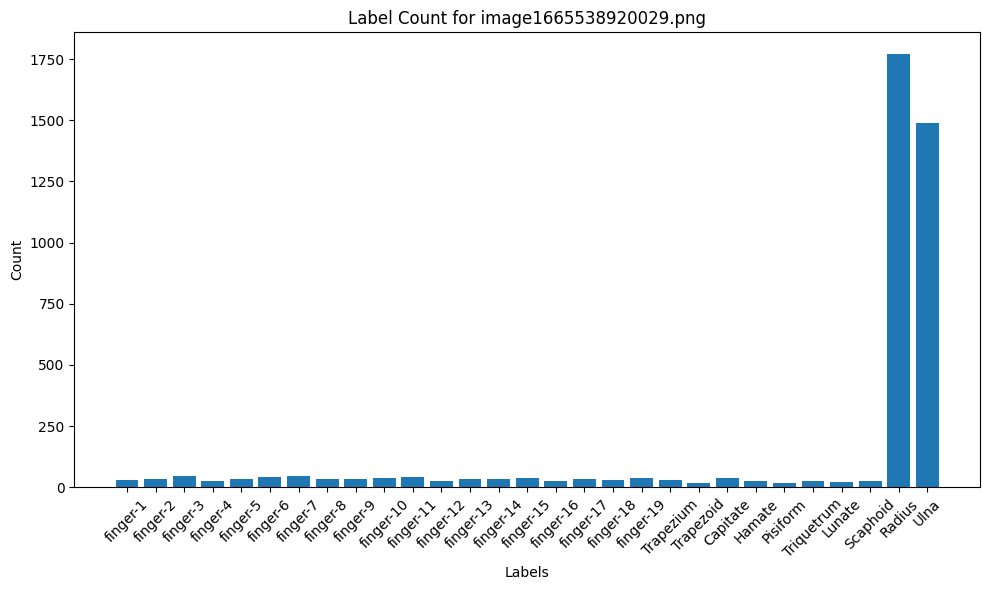

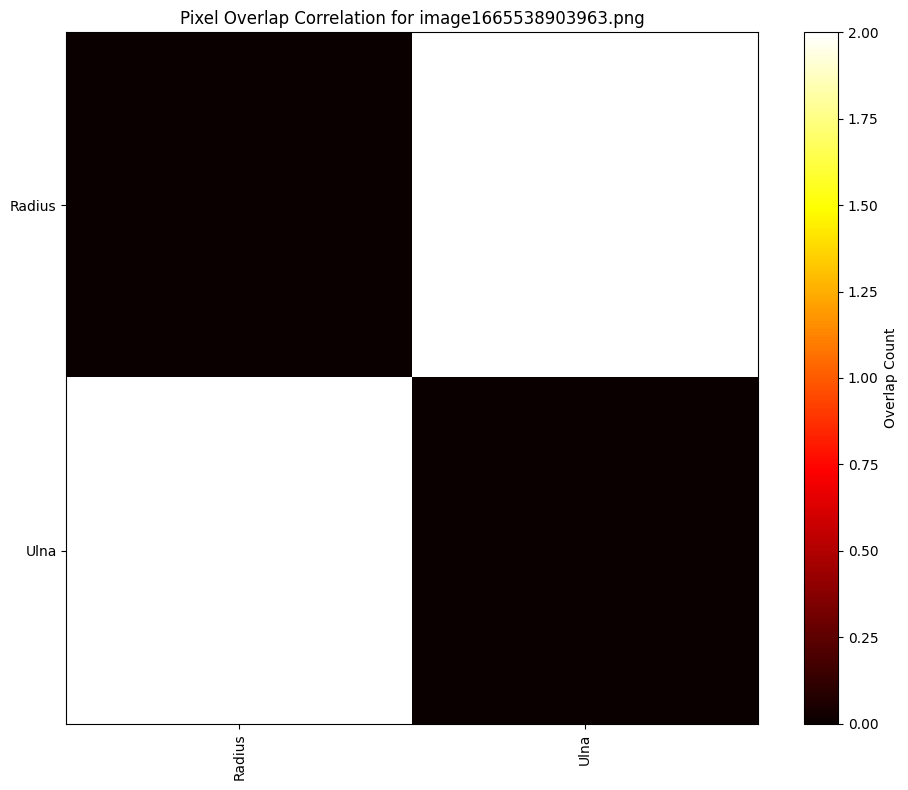

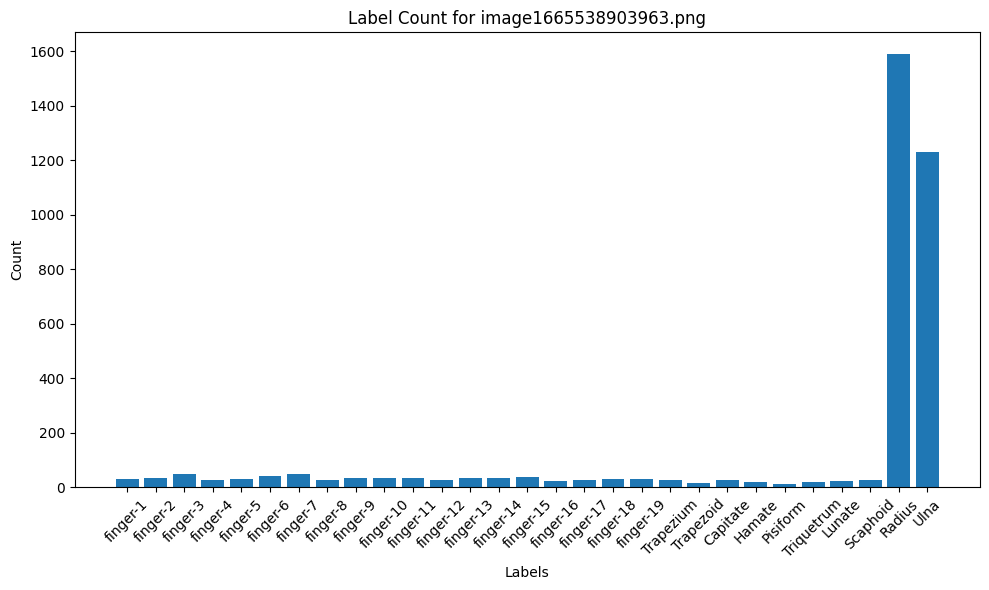

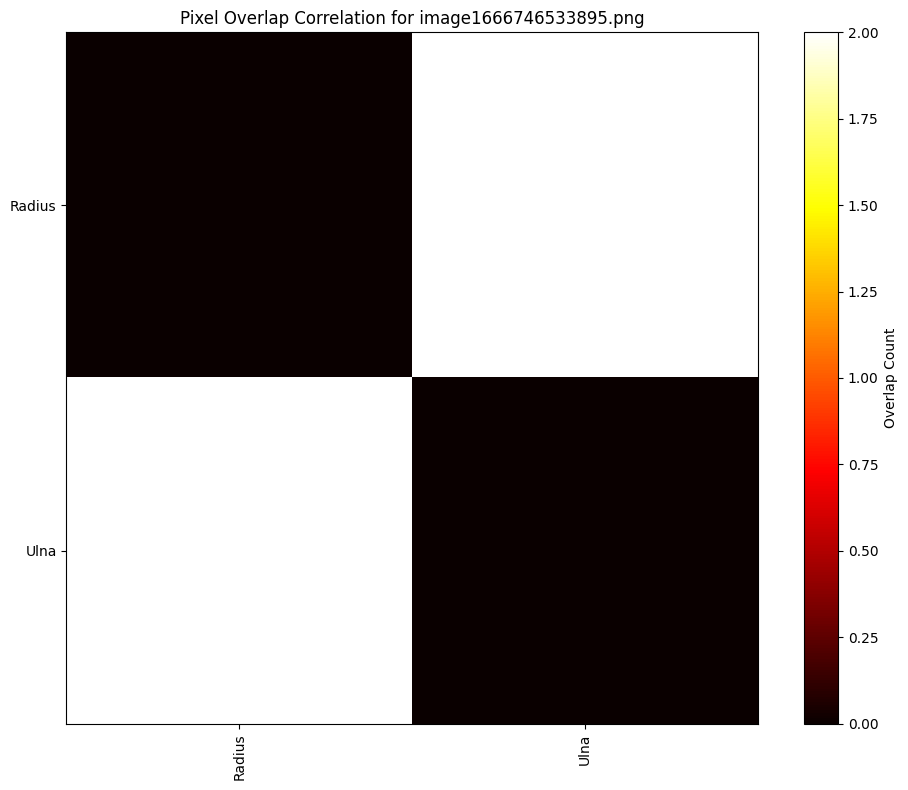

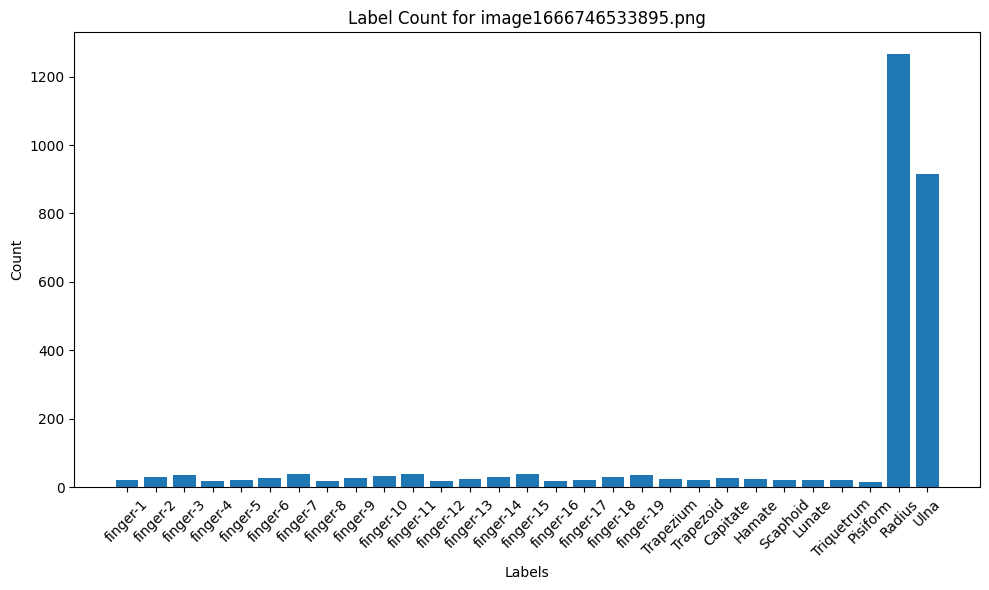

TypeError: Invalid shape (0,) for image data

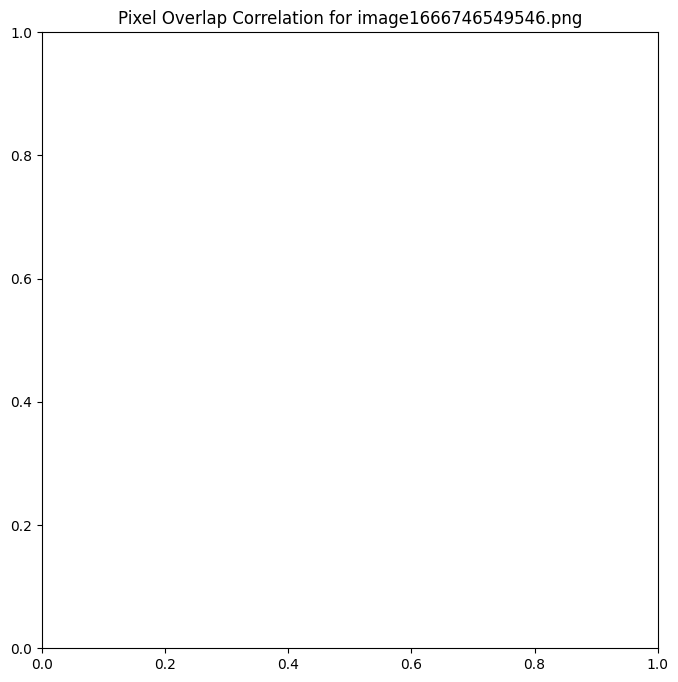

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# CSV 파일 읽기
df = pd.read_csv('./train_annotation.csv')

# 이미지별 레이블과 픽셀 정보 저장
image_labels = defaultdict(list)

for _, row in df.iterrows():
    img_name = row['img_name']
    annotation = json.loads(row['annotation'].replace("'", "\""))
    label = annotation['label']
    points = annotation['points']
    image_labels[img_name].append((label, points))

# 픽셀이 겹치는 레이블 간의 상관관계 계산
def calculate_overlap(label_points):
    overlap_matrix = defaultdict(lambda: defaultdict(int))
    
    for i, (label1, points1) in enumerate(label_points):
        for j, (label2, points2) in enumerate(label_points):
            if i < j:  # 중복 계산 방지
                # 겹치는 픽셀 수 계산
                overlap_count = len(set(map(tuple, points1)) & set(map(tuple, points2)))
                if overlap_count > 0:
                    overlap_matrix[label1][label2] += overlap_count
                    overlap_matrix[label2][label1] += overlap_count

    return overlap_matrix

# 차트 그리기
for img_name, labels in image_labels.items():
    overlap_matrix = calculate_overlap(labels)

    # 상관관계 차트
    plt.figure(figsize=(10, 8))
    plt.title(f'Pixel Overlap Correlation for {img_name}')
    plt.imshow([[overlap_matrix[label1].get(label2, 0) for label2 in overlap_matrix] for label1 in overlap_matrix], cmap='hot', interpolation='nearest')
    plt.xticks(range(len(overlap_matrix)), list(overlap_matrix.keys()), rotation=90)
    plt.yticks(range(len(overlap_matrix)), list(overlap_matrix.keys()))
    plt.colorbar(label='Overlap Count')
    plt.tight_layout()
    plt.show()

    # 레이블 개수 차트
    label_counts = {label: len(points) for label, points in labels}
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title(f'Label Count for {img_name}')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from PIL import Image, ImageDraw
import seaborn as sns
# CSV 파일 불러오기
file_path = "./train_annotation.csv"
df = pd.read_csv(file_path)

# 각 라벨에 대해 마스크를 생성
def create_mask(points, img_size=(2048, 2048)):
    """points로부터 binary 마스크 생성"""
    mask = Image.new('L', img_size, 0)
    points = [tuple(point) for point in points]  # 좌표를 튜플로 변환
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    return np.array(mask)

# 겹치는 픽셀 개수 계산
overlap_data = []

# 각 이미지 그룹에 대해 라벨 간 겹치는 픽셀 수 계산
for img_name, group in df.groupby('img_name'):
    labels = group['label'].unique()
    label_masks = {}
    
    # 각 라벨에 대해 마스크 생성 및 저장
    for label in labels:
        points_list = group[group['label'] == label]['points']
        mask = np.zeros((2048, 2048), dtype=np.uint8)
        for points in points_list:
            polygon = eval(points)
            mask += create_mask(polygon)
        label_masks[label] = mask.clip(0, 1)  # 중복 영역은 1로 제한

    # 라벨 조합별로 겹치는 픽셀 수 계산
    for label1, label2 in combinations(labels, 2):
        overlap_count = np.sum((label_masks[label1] & label_masks[label2]) > 0)
        overlap_data.append([img_name, f"{label1}-{label2}", overlap_count])

# 데이터프레임으로 변환
overlap_df = pd.DataFrame(overlap_data, columns=['img_name', 'label_pair', 'overlap_pixels'])

# 겹치는 픽셀 수 막대 차트 그리기
plt.figure(figsize=(12, 6))
sns.barplot(data=overlap_df, x='label_pair', y='overlap_pixels', hue='img_name')
plt.xticks(rotation=90)
plt.title("Overlap Pixels per Label Pair in Each Image")
plt.xlabel("Label Pair")
plt.ylabel("Number of Overlapping Pixels")
plt.legend(title="Image Name")
plt.show()

KeyboardInterrupt: 